In [ ]:
from matplotlib import pyplot as plt
from Architectures.AE import AE
from Architectures.GAN import GAN
from Architectures.VAE import VAE
from Architectures.PCA import PCA
from Data.load import load
import numpy as np
from Metrics.metrics import NRMSE
from tqdm import tqdm

In [13]:
models = {
    "VAE-20": VAE.open("Trained Models/VAE/20"),
    "VAE-d35": VAE.open("Trained Models/VAE/diff_35"),
    "VAE-d32": VAE.open("Trained Models/VAE/diff_32"),
    "VAE-200": VAE.open("Trained Models/VAE/200"),
    "AE-10": AE.open("Trained Models/AE/10"),
    "AE-30": AE.open("Trained Models/AE/30"),
    "AE-50": AE.open("Trained Models/AE/50"),
    "AE-100": AE.open("Trained Models/AE/100"),
    "AE-300": AE.open("Trained Models/AE/300"),
    "AE-360": AE.open("Trained Models/AE/360"),
    "AE-500": AE.open("Trained Models/AE/500"),
    "AE-1000": AE.open("Trained Models/AE/1000"),
    "AE-256.1": AE.open("Trained Models/AE/optimal_depths/(1, 1, 1)"),
    "AE-256.2": AE.open("Trained Models/AE/optimal_depths/(2, 4, 8)"),
    "AE-256.3": AE.open("Trained Models/AE/optimal_depths/(4, 8, 16)"),
    "AE-256.4": AE.open("Trained Models/AE/optimal_depths/(8, 16, 32)"),
    # "PCA-30K": PCA.open("Trained Models/PCA/30k"),
}

Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.


In [4]:
groups = {
    group: load(f"Pre-processed/{group}",train_test_split=1) # take=5
    for group in ["CN","MCI","AD"]
}

Loading AD: 100%|██████████| 213/213 [02:14<00:00,  1.58it/s]


In [ ]:
for group in tqdm(groups,"Saving cropped images"):
    np.save(open(f"Data/{group}.npy","bw"),groups[group])

Saving cropped images: 100%|██████████| 3/3 [01:18<00:00, 26.12s/it]


In [14]:
for group in tqdm(["CN","MCI","AD"],"Opening faster"):
    groups[group]=np.load(open(f"Data/{group}.npy","br"))

Opening faster: 100%|██████████| 3/3 [00:19<00:00,  6.47s/it]


In [ ]:
def get_recon_loss(model, x, metric = NRMSE):
    latent = model.encoder.predict(x)
    if isinstance(latent, list):
        latent = latent[0]
    recon = model.decoder.predict(latent)
    return np.array([metric(recon[i],x[i]) for i in range(len(x))])

def get_recon_loss_all(model, groups, metric = NRMSE):
    return {g_name: get_recon_loss(model, g_x, metric) for g_name, g_x in groups.items()}

def get_avg_loss_all_models(models, x):
    loss = np.zeros(x)
    for model in models:
        latent = model.encoder.predict(x)
        if isinstance(latent, list):
            latent = latent[0]
        loss += x - model.decoder.predict(latent).reshape(x.shape)
    loss /= len(models)
    return loss

group_losses = {g_name:get_avg_loss_all_models(models.values(), groups[g_name]) for g_name in groups}

model_losses = {m_name:get_recon_loss_all(m, groups) for m_name, m in models.items()}
# model_losses

ValueError: maximum supported dimension for an ndarray is 32, found 1326

: 

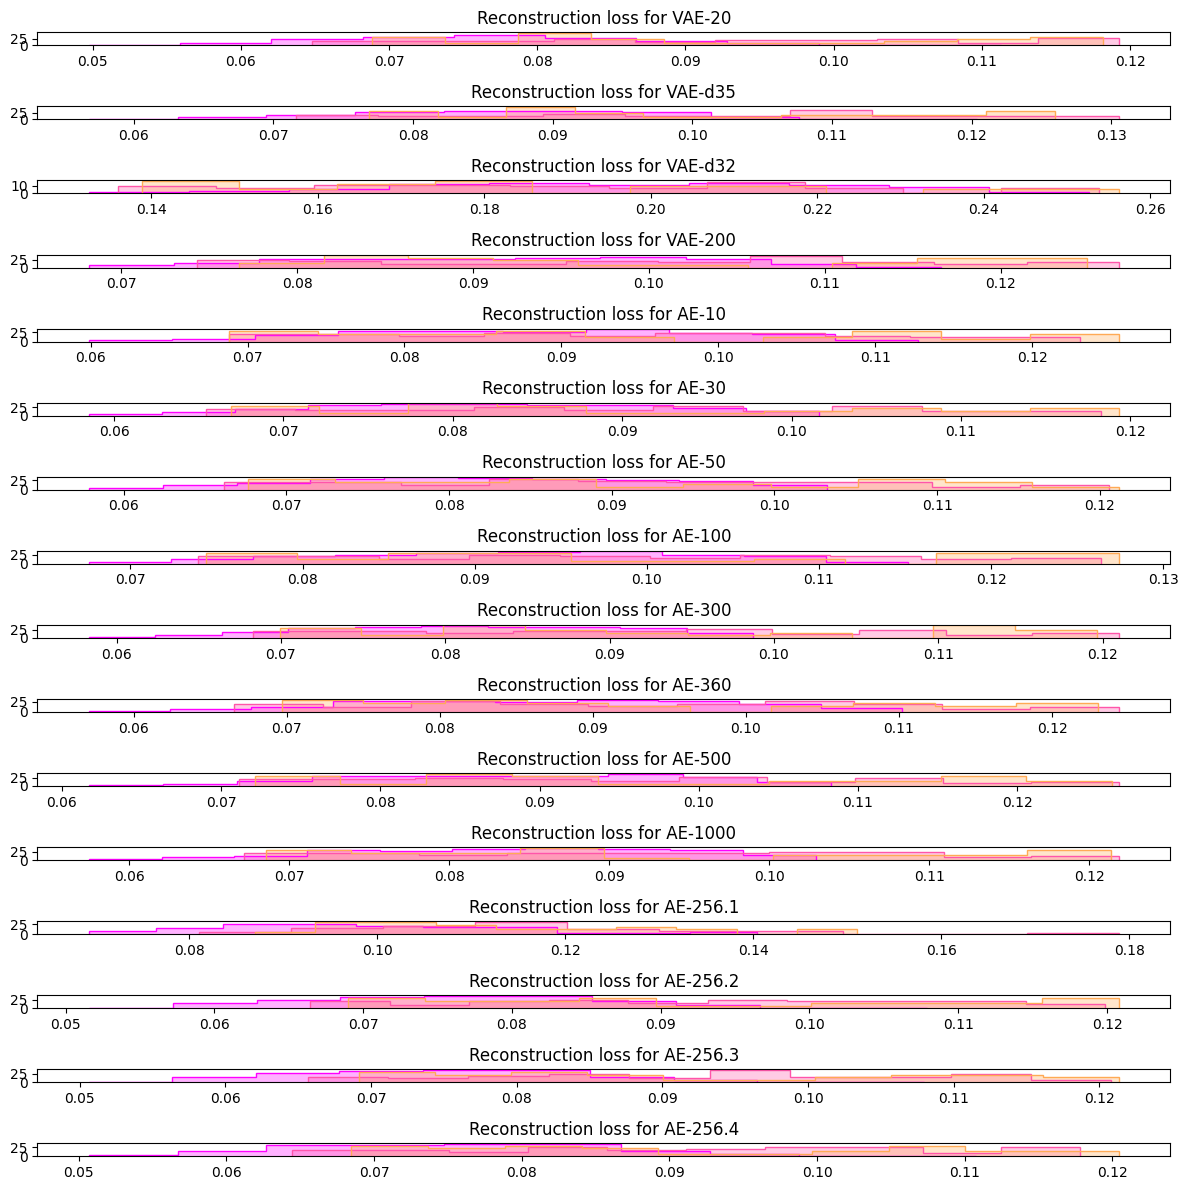

In [13]:
cmap = plt.get_cmap("spring")  # Get the "spring" colormap
plt.figure(figsize=(12,12))
num_groups = max(len(m_loss) for m_loss in model_losses.values())  # Max number of groups in any model

row_idx = 1
for m_name, m_loss in model_losses.items():
    plt.subplot(len(model_losses), 1, row_idx)
    plt.title(f"Reconstruction loss for {m_name}")
    
    for i, (g_name, g_loss) in enumerate(m_loss.items()):
        color = cmap(i / num_groups)  # Get a color from the colormap
        plt.hist(g_loss, label=g_name, color=color, alpha=0.3, density=True) # Fill
        plt.hist(g_loss, color=color, histtype="step", density=True) # Outline
    
    # plt.legend()
    row_idx += 1

plt.tight_layout()
plt.show()


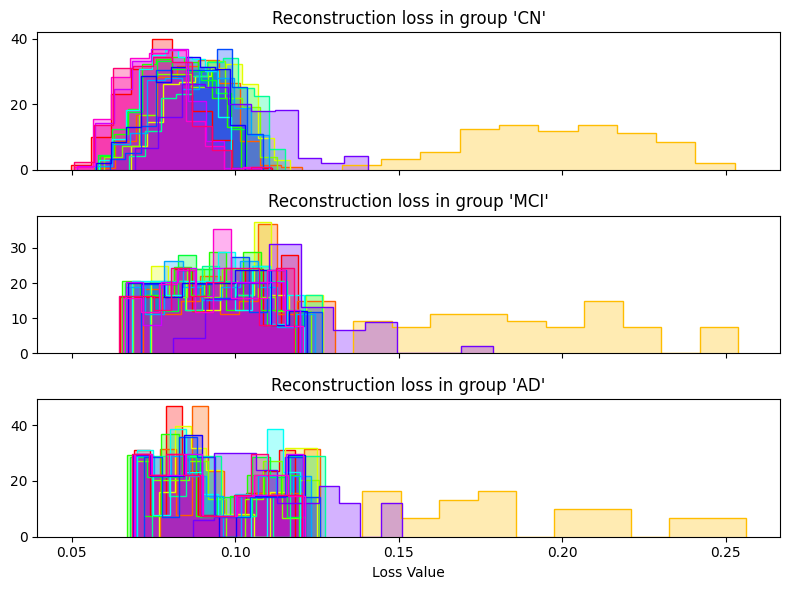

In [17]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap("hsv")  # Get the "hsv" colormap
num_groups = len(models)

fig, axes = plt.subplots(len(groups), 1, sharex=True, figsize=(8, 6))

if len(groups) == 1:
    axes = [axes]  # Ensure axes is always iterable

for row_idx, (ax, group_name) in enumerate(zip(axes, groups), start=1):
    ax.set_title(f"Reconstruction loss in group '{group_name}'")
    for i, (m_name, m_loss) in enumerate(model_losses.items()):
        color = cmap(i / num_groups)  # Get a color from the colormap
        ax.hist(m_loss[group_name], label=m_name, color=color, alpha=0.3, density=True)  # Fill
        ax.hist(m_loss[group_name], color=color, histtype="step", density=True)  # Outline
    
    if row_idx == len(groups):
        ax.set_xlabel("Loss Value")  # Label x-axis only for the bottom plot

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Mean reconstruction loss')

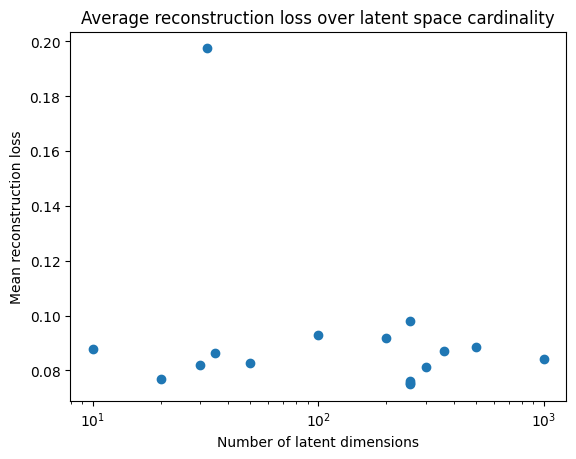

In [19]:
dim = {m_name: float(m_name[m_name.index("-")+1:].replace("d","")) for m_name in models}
mean_loss = {m_name: np.mean(m_loss["CN"]) for m_name, m_loss in model_losses.items()}
plt.scatter(dim.values(), mean_loss.values())
plt.xscale("log")
plt.title("Average reconstruction loss over latent space cardinality")
plt.xlabel("Number of latent dimensions")
plt.ylabel("Mean reconstruction loss")

Loading AD: 100%|██████████| 26/26 [00:10<00:00,  2.46it/s]


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


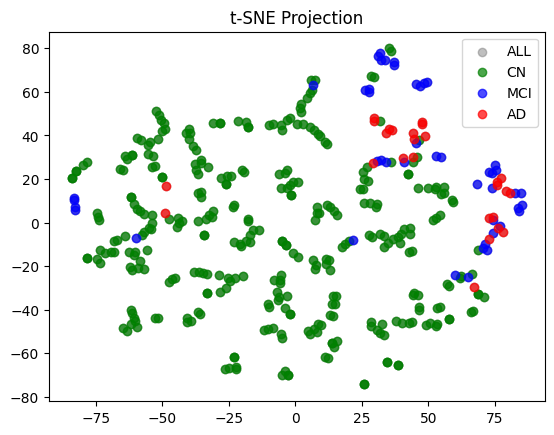

In [17]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Function to plot t-SNE projection
def pTSNE(model, datasets, colors, labels, ax, perplexity=5, title="t-SNE Projection"):
    """
    Plots the t-SNE projection of the encoded representation of the dataset.

    Parameters:
    - model: The model used for encoding the dataset.
    - dataset: The dataset to be encoded and projected.
    - color: The color used for the scatter plot.
    - label: The label for the dataset in the legend.
    - perplexity: The perplexity parameter for t-SNE (default is 5).
    - title: The title for the plot (default is 't-SNE Projection').
    """
    combined_data = np.concatenate(datasets, axis=0)
    scaler = StandardScaler()
    combined_data_scaled = scaler.fit_transform(combined_data.reshape(-1, combined_data.shape[-1])).reshape(combined_data.shape)
    z_mean = model.encoder.predict(combined_data_scaled)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    
    
    r = tsne.fit_transform(z_mean)
    ax.scatter(r[:, 0], r[:, 1], color="gray", label="ALL", alpha=0.5)
    
    start_idx = 0
    for dataset, color, label in zip(datasets, colors, labels):
        end_idx = start_idx + len(dataset)
        ax.scatter(r[start_idx:end_idx, 0], r[start_idx:end_idx, 1], 
                   color=color, label=label, alpha=0.7)
        start_idx = end_idx


    ax.set_title(title)
    ax.legend()

# labels = list(groups.keys())
# colors = ["g","b","r"] # What Kiran used
# datasets = list(groups.values())

fig, ax = plt.subplots()
labels = ["CN", "MCI", "AD"]
colors = ["g","b","r"] # What Kiran used
datasets = [load(f"Pre-processed/{label}", train_test_split=1) for label in labels]
pTSNE(models["AE-100"], datasets, colors, labels, ax)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


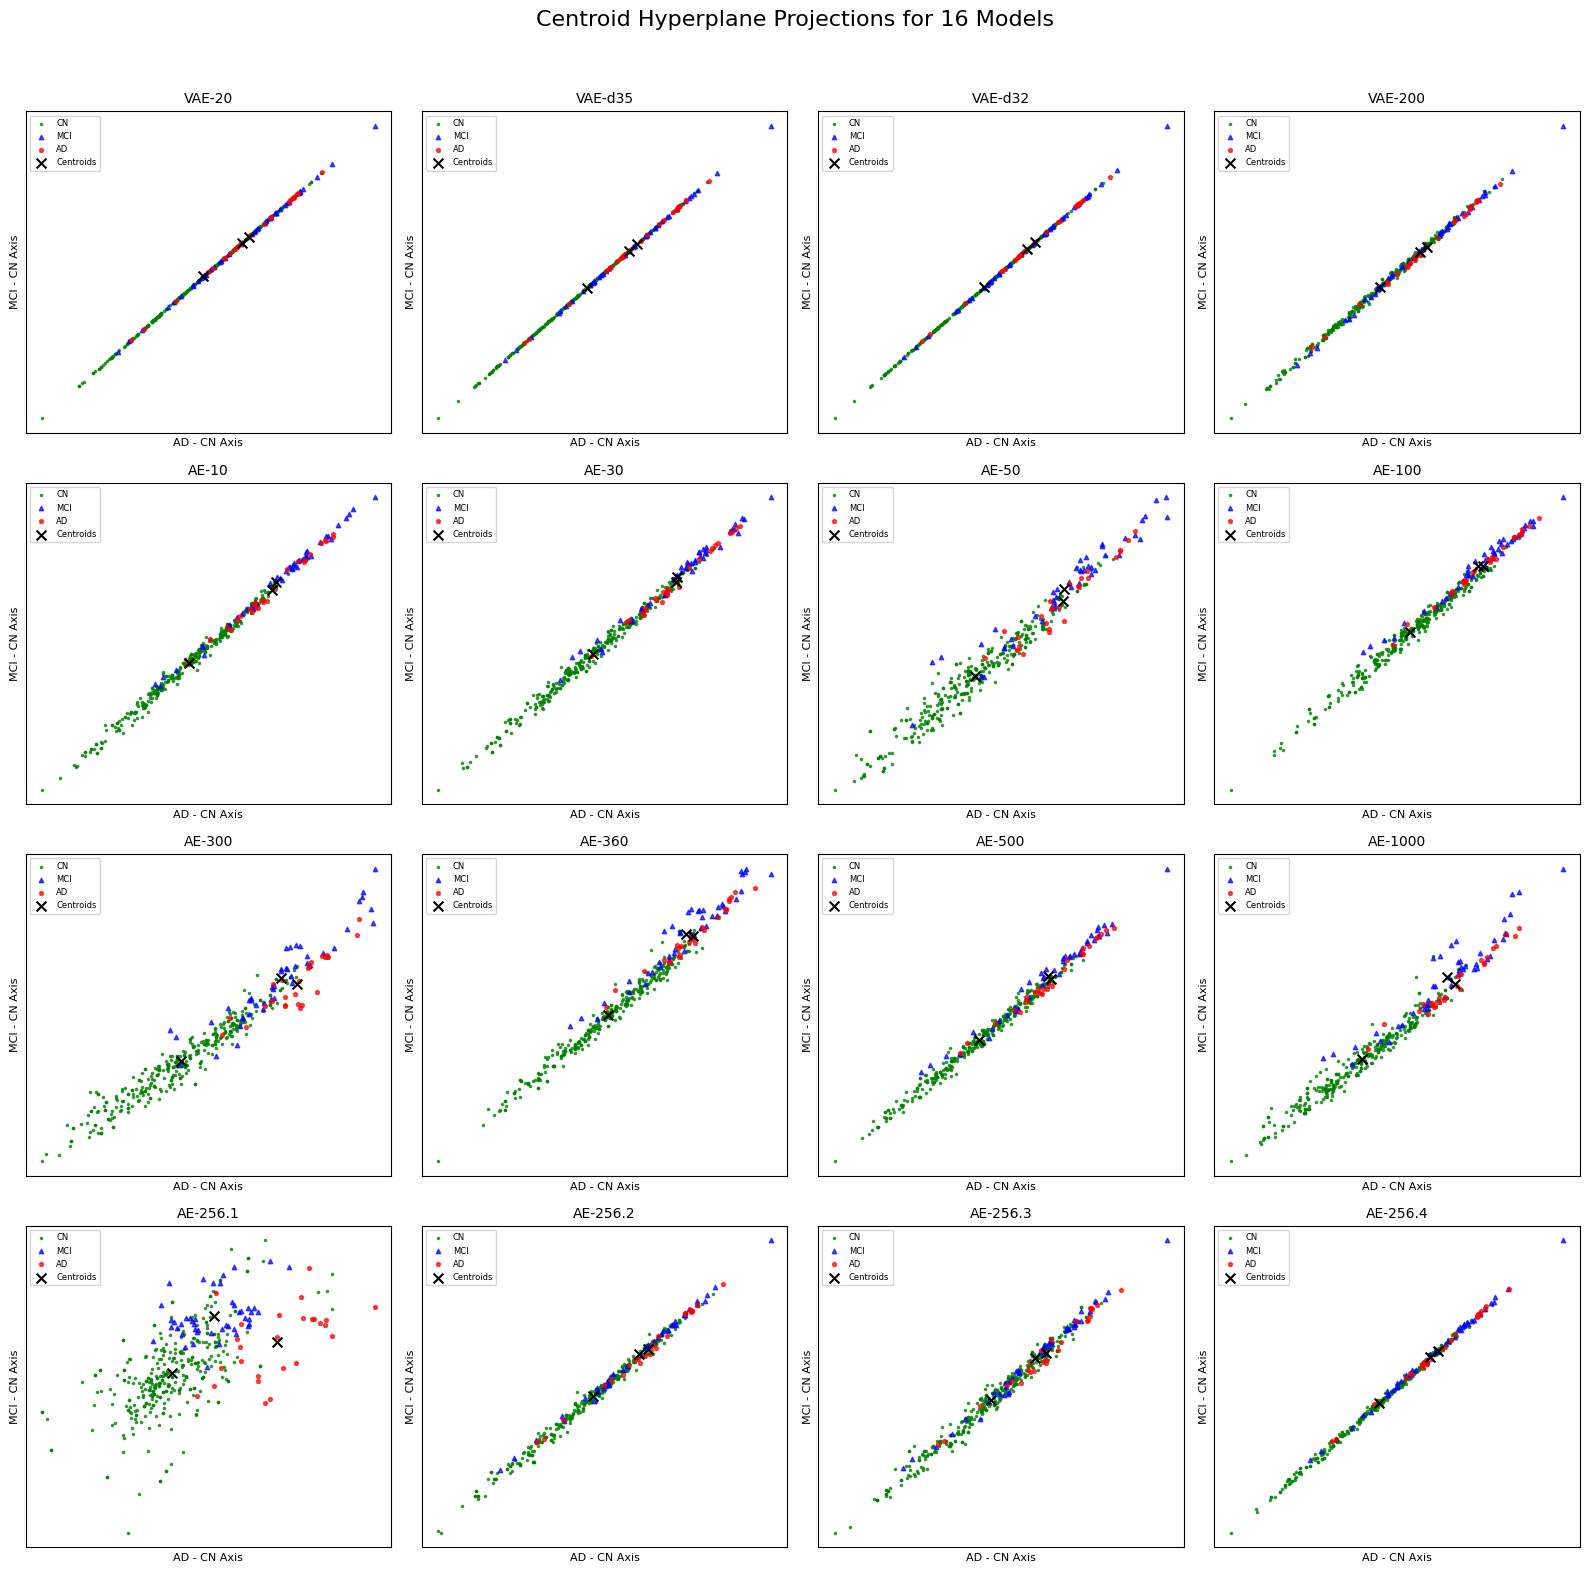

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def centroid_hyperplane_plot(model, datasets, colors, labels, ax, title):
    """
    Projects data points onto a 2D hyperplane defined by centroid differences and plots them.

    Parameters:
    - model: The model used for encoding the dataset.
    - datasets: List of datasets to be encoded and projected.
    - colors: List of colors for different datasets.
    - labels: List of labels for different groups (e.g., "CN", "MCI", "AD").
    - ax: The subplot axis for plotting.
    - title: Title for the subplot (model name).
    """
    # Combine and normalize dataset
    combined_data = np.concatenate(datasets, axis=0)
    
    # Get latent space representations
    z = model.encoder.predict(combined_data)
    if isinstance(z, list):
        z = z[0]  # Handle multi-output models

    # scaler = 
    z = StandardScaler().fit_transform(z)

    # Compute centroids
    centroids = {}
    i = 0
    for j, group in enumerate(labels):
        group_size = len(datasets[j])
        centroids[group] = np.mean(z[i:i+group_size], axis=0)  # Mean along feature axis
        i += group_size

    # Define the hyperplane axes
    ax_1 = centroids["AD"] - centroids["CN"]  # Difference between AD and CN
    ax_2 = centroids["MCI"] - centroids["CN"]  # Difference between MCI and CN

    # Project the latent representations onto the new 2D space
    projected_data = np.array([[np.dot(point - centroids["CN"], ax_1), 
                                np.dot(point - centroids["CN"], ax_2)] for point in z])

    # Plot the projected data
    i = 0
    markers = ".^p"
    for j, (dataset, color, label) in enumerate(zip(datasets, colors, labels)):
        group_size = len(dataset)
        ax.scatter(projected_data[i:i+group_size, 0], 
                   projected_data[i:i+group_size, 1], 
                   color=color, label=label, alpha=0.7, s=10, marker=markers[j])
        i += group_size

    # Plot centroid locations
    centroid_proj = np.array([[np.dot(centroids[group] - centroids["CN"], ax_1), 
                               np.dot(centroids[group] - centroids["CN"], ax_2)] 
                               for group in labels])

    ax.scatter(centroid_proj[:, 0], centroid_proj[:, 1], c="black", marker="x", s=50, label="Centroids")

    ax.set_xlabel("AD - CN Axis", fontsize=8)
    ax.set_ylabel("MCI - CN Axis", fontsize=8)
    ax.set_title(title, fontsize=10)

    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_frame_on(False)
    ax.grid(True, alpha=0.5)
    ax.legend(fontsize=6, loc="best")

# Create a 4x4 grid of plots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle("Centroid Hyperplane Projections for 16 Models", fontsize=16)

for ax, (model_name, model) in zip(axes.flat, models.items()):
    centroid_hyperplane_plot(model, datasets, colors, labels, ax, title=model_name)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


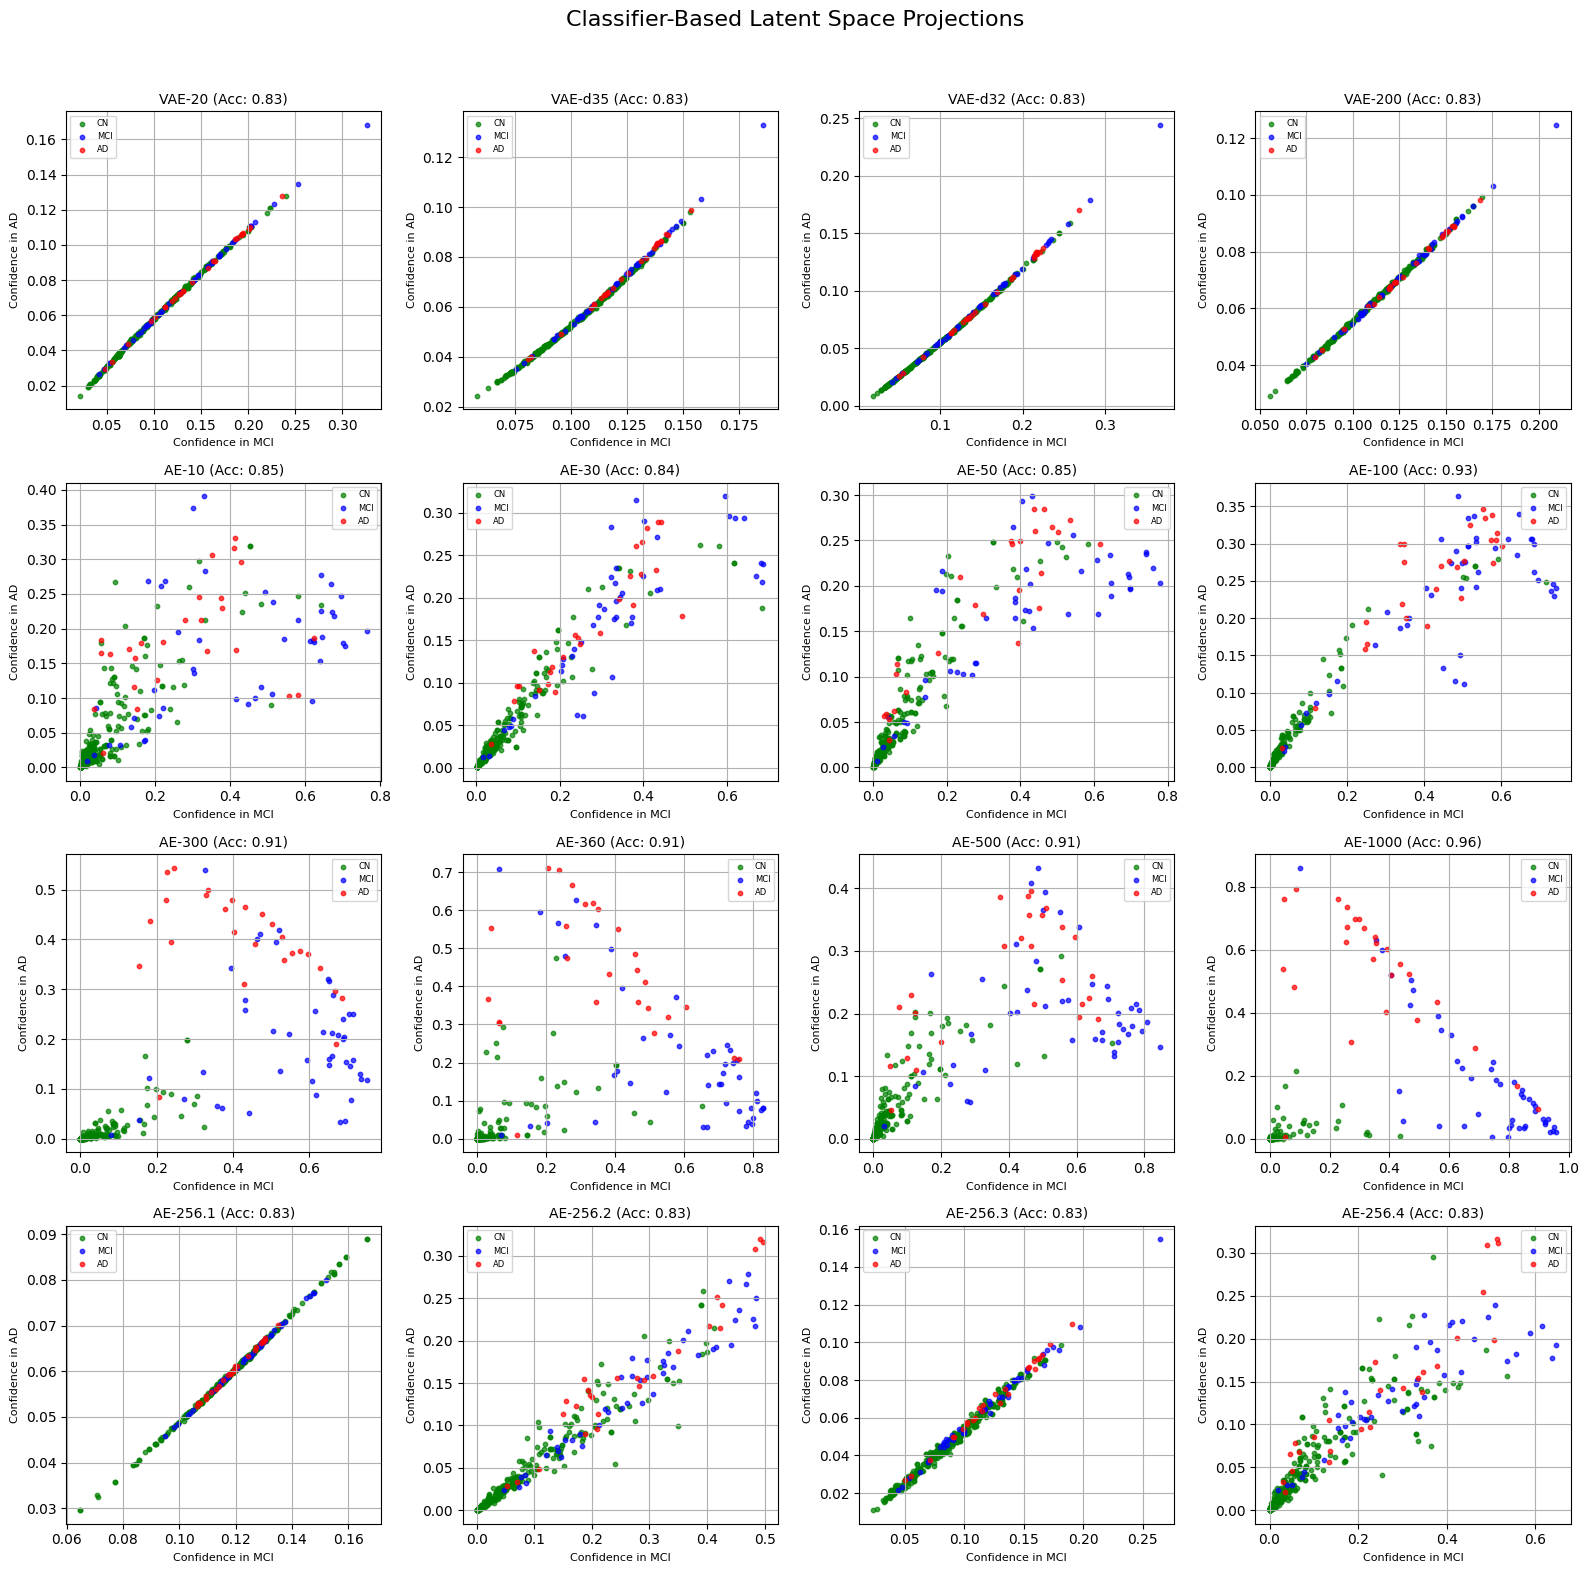

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def classifier_latent_plot(model, datasets, colors, labels, ax, title):
    """
    Trains a classifier on the latent space and plots the predictions' confidence scores.

    Parameters:
    - model: The encoder model used for extracting latent space representations.
    - datasets: List of datasets corresponding to different classes (CN, MCI, AD).
    - colors: List of colors for different datasets.
    - labels: List of class labels.
    - ax: The subplot axis for plotting.
    - title: The subplot title (model name).
    """
    # Combine and normalize dataset
    combined_data = np.concatenate(datasets, axis=0)
    # scaler = StandardScaler()
    # combined_data_scaled = scaler.fit_transform(combined_data.reshape(-1, combined_data.shape[-1])).reshape(combined_data.shape)

    # Get latent space representations
    z = model.encoder.predict(combined_data)
    if isinstance(z, list):
        z = z[0]  # Handle multi-output models

    # Create labels for classification
    y = np.concatenate([np.full(len(datasets[i]), i) for i in range(len(datasets))])  # 0: CN, 1: MCI, 2: AD

    # Train classifier on latent space
    X_train, X_test, y_train, y_test = train_test_split(z, y, test_size=0.2, random_state=42, stratify=y)
    
    clf = MLPClassifier(hidden_layer_sizes=(32,), max_iter=500, random_state=42)
    clf.fit(X_train, y_train)
    
    # Get confidence scores for entire dataset
    confidences = clf.predict_proba(z)  # Shape (N, 3) → columns are [P(CN), P(MCI), P(AD)]
    
    # Accuracy check (optional)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    # Use P(MCI) and P(AD) as x and y axes
    x_coords = confidences[:, 1]  # Confidence in MCI
    y_coords = confidences[:, 2]  # Confidence in AD
    
    # Scatter plot
    i = 0
    for j, (dataset, color, label) in enumerate(zip(datasets, colors, labels)):
        group_size = len(dataset)
        ax.scatter(x_coords[i:i+group_size], y_coords[i:i+group_size], 
                   color=color, label=label, alpha=0.7, s=10)
        i += group_size

    ax.set_xlabel("Confidence in MCI", fontsize=8)
    ax.set_ylabel("Confidence in AD", fontsize=8)
    ax.set_title(f"{title} (Acc: {acc:.2f})", fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=6, loc="best")

# Create a 4x4 grid of plots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle("Classifier-Based Latent Space Projections", fontsize=16)

for ax, (model_name, model) in zip(axes.flat, models.items()):
    classifier_latent_plot(model, datasets, colors, labels, ax, title=model_name)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


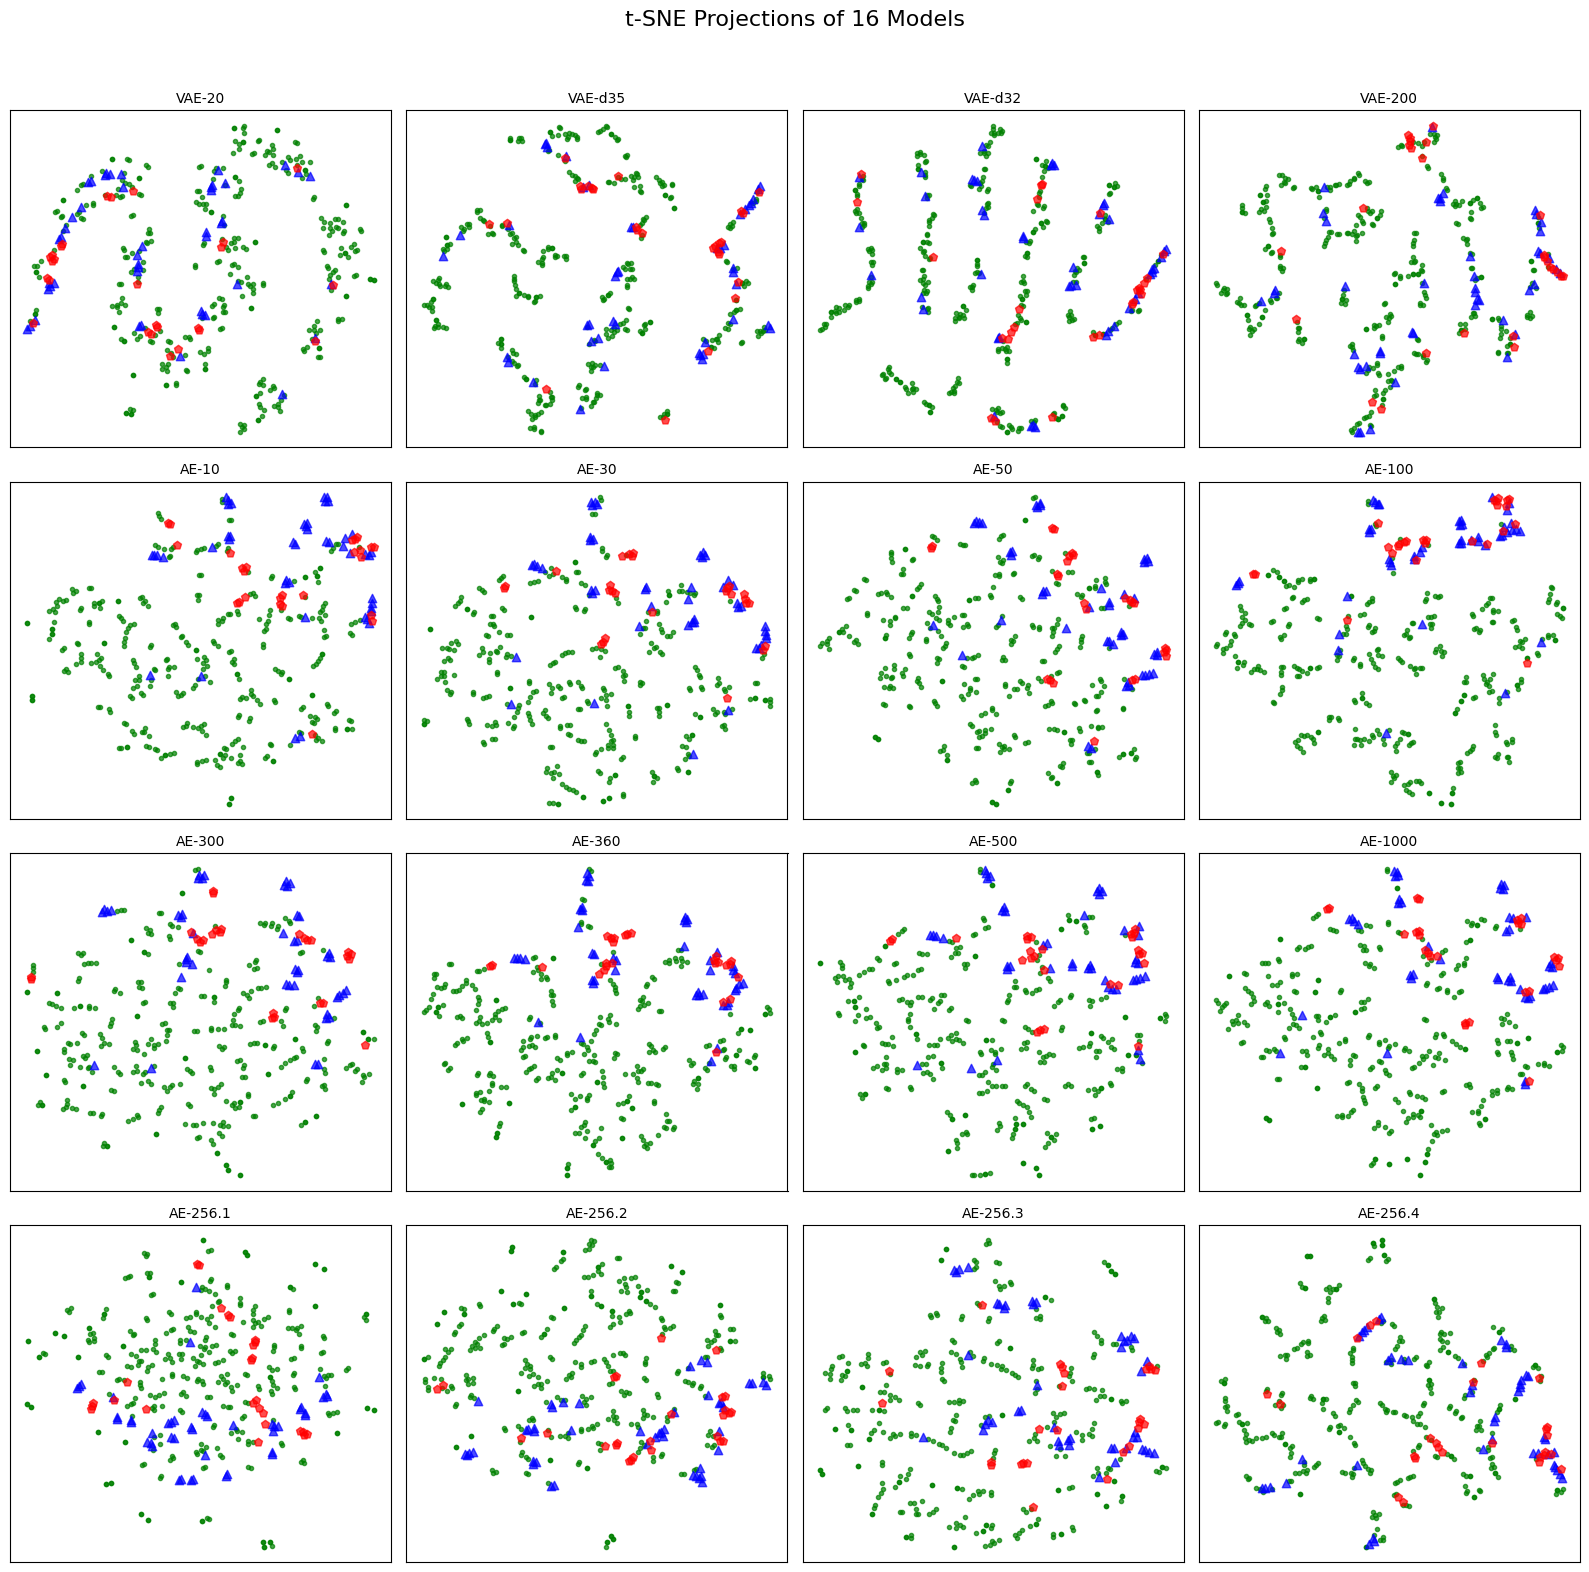

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Function to plot t-SNE projection
def pTSNE(model, datasets, colors, labels, ax, perplexity=5, title="t-SNE Projection"):
    """
    Plots the t-SNE projection of the encoded representation of the dataset.

    Parameters:
    - model: The model used for encoding the dataset.
    - datasets: List of datasets to be encoded and projected.
    - colors: List of colors for different datasets.
    - labels: List of labels for the legend.
    - ax: The subplot axis for plotting.
    - perplexity: The perplexity parameter for t-SNE (default is 5).
    - title: The title for the plot.
    """
    combined_data = np.concatenate(datasets, axis=0)
    # scaler = StandardScaler()
    # combined_data_scaled = scaler.fit_transform(combined_data.reshape(-1, combined_data.shape[-1])).reshape(combined_data.shape)
    
    z_mean = model.encoder.predict(combined_data)
    if isinstance(z_mean, list):
        z_mean = z_mean[0]
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    r = tsne.fit_transform(z_mean)
    
    # ax.scatter(r[:, 0], r[:, 1], color="gray", label="ALL", alpha=0.5)
    
    start_idx = 0
    markers = ".^p"
    i=0
    for dataset, color, label in zip(datasets, colors, labels):
        end_idx = start_idx + len(dataset)
        ax.scatter(r[start_idx:end_idx, 0], r[start_idx:end_idx, 1], 
                   color=color, label=label, alpha=0.7, marker=markers[i])
        i+=1
        start_idx = end_idx

    ax.set_title(title, fontsize=10)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, alpha=0.5)
    # ax.set_frame_on(False)
    # ax.legend(fontsize=8)

# Assuming `models` is a dictionary of 16 models
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle("t-SNE Projections of 16 Models", fontsize=16)

for ax, (model_name, model) in zip(axes.flat, models.items()):
    pTSNE(model, datasets, colors, labels, ax, title=model_name)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
